<h1>Load Data</h1>
<p>Set the Hadoop configuration.</p>

In [1]:
import requests, StringIO, pandas as pd, json, re

In [2]:
# Configure the hadoop HDFS
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name']
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v2.0/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [3]:
# Data Attibribute setting
credentials_1 = {
    'auth_url' : 'https://identity.open.softlayer.com',
    'project' : 'object_storage_c0d55fcc_17c8_4eaa_a7ff_b6efc1d875dc',
    'project_id' : '0cfe566596454ec382e61cf81c21b5cc',
    'region' : 'dallas',
    'user_id' : '2b54c89db13345198e2171f30bc231b7',
    'domain_id' : 'b80ce6694ed04fd0adb155c41a4b4208',
    'domain_name' : '933407',
    'username' : 'Admin_efaace8dc803c2350da34b29935e05dc56627219',
    'password' : 'k(Ep[0]ro.zfRPL5',
    'filename' : 'health_expenditures.csv',
    'container' : 'notebooks',
    'tenantId' : 's1d0-291d54bf2d4b07-17225d6d0eeb'
}

In [4]:
# config Hadoop HDFS
credentials_1['name'] = 'keystone'
set_hadoop_config(credentials_1)

In [5]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

expenditures = sc.textFile("swift://notebooks." + credentials_1['name'] + "/health_expenditures.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

expenditures_header = expenditures.first()

expenditures_header_list = expenditures_header.split(",")
expenditures_body = expenditures.mapPartitionsWithIndex(skip_header)

# create Spark DataFrame using pyspark-csv
expenditures_df = pycsv.csvToDataFrame(sqlContext, expenditures_body, sep = ",", columns = expenditures_header_list)

In [6]:
life_expectancy = sc.textFile("swift://notebooks." + credentials_1['name'] + "/life_expectancy_at_birth.csv")

life_expectancy_header = life_expectancy.first()

life_expectancy_header_list = life_expectancy_header.split(",")
life_expectancy_body = life_expectancy.mapPartitionsWithIndex(skip_header)

# create Spark DataFrame using pyspark-csv
life_expectancy_df = pycsv.csvToDataFrame(sqlContext, life_expectancy_body, sep = ",", columns = life_expectancy_header_list)

In [7]:
hivaids = sc.textFile("swift://notebooks." + credentials_1['name'] + "/hivaids_-_people_living_with_hivaids.csv")

hivaids_header = hivaids.first()

hivaids_header_list = hivaids_header.split(",")
hivaids_body = hivaids.mapPartitionsWithIndex(skip_header)

# create Spark DataFrame using pyspark-csv
hivaids_df = pycsv.csvToDataFrame(sqlContext, hivaids_body, sep = ",", columns = hivaids_header_list)

<h1>Process Data using pyspark.sql</h1>
<p>Set the Hadoop configuration.</p>

In [8]:
# Python expressions in a code cell will be outputted after computation
expenditures_df.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- (% OF GDP): double (nullable = true)
 |-- Date of Information: integer (nullable = true)



In [9]:
# Sorting the data using spark sql
from pyspark.sql.functions import desc, asc

factor = expenditures_df.sort(desc('(% OF GDP)')).limit(10).toPandas()
factor_re = expenditures_df.sort(asc('(% OF GDP)')).limit(10).toPandas()

In [10]:
print factor

   Rank                          Country  (% OF GDP)  Date of Information
0     1                    United States        17.9                 2012
1     2                 Marshall Islands        15.6                 2012
2     3                          Liberia        15.5                 2012
3     4                           Tuvalu        15.4                 2012
4     5                     Sierra Leone        15.1                 2012
5     6  Micronesia, Federated States of        12.8                 2012
6     7                      Netherlands        12.4                 2012
7     8                          Moldova        11.7                 2012
8     9                           France        11.7                 2012
9    10                          Lesotho        11.6                 2012


In [11]:
life = life_expectancy_df.sort(desc('(YEARS)')).limit(10).toPandas()
life_re = life_expectancy_df.sort(asc('(YEARS)')).limit(10).toPandas()

In [12]:
hivaids_df.head()

Row(Rank=1, Country=u'South Africa', HIV/AIDS - PEOPLE LIVING WITH HIV/AIDS=6836500, Date of Information=u'2014 est.')

In [13]:
print hivaids_df.columns
newhivaids_df = hivaids_df.withColumnRenamed("HIV/AIDS - PEOPLE LIVING WITH HIV/AIDS", "HIV")
newhivaids_df.printSchema()

['Rank', 'Country', 'HIV/AIDS - PEOPLE LIVING WITH HIV/AIDS', 'Date of Information']
root
 |-- Rank: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- HIV: integer (nullable = true)
 |-- Date of Information: string (nullable = true)



In [14]:
aids = newhivaids_df.sort(desc('HIV')).limit(10).toPandas()

<h1>Raw analysis</h1>
<p>Statistical Result of the data</p>

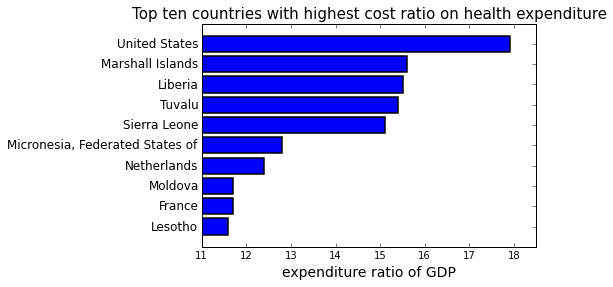

In [15]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.barh(range(10),factor.sort('(% OF GDP)', ascending=True)['(% OF GDP)'], color='blue', align = 'center', linewidth = 1.5)
plt.title('Top ten countries with highest cost ratio on health expenditure', size=15)
plt.xlabel('expenditure ratio of GDP', size=14)
# plt.ylabel('Countries', size=12)
plt.yticks(range(len(factor))[::-1], factor['Country'][::-1], size=12)
plt.xlim((11,18.5))
plt.ylim((-1,10))
plt.show()

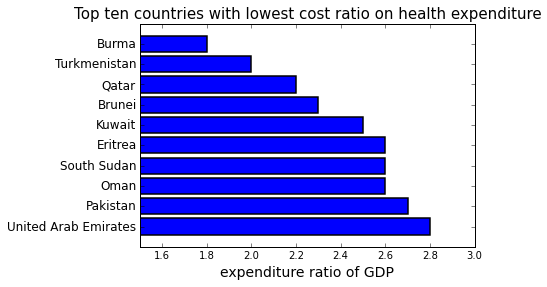

In [16]:
plt.barh(range(10),factor_re.sort('(% OF GDP)', ascending=False)['(% OF GDP)'], color='blue', align = 'center', linewidth = 1.5)
plt.title('Top ten countries with lowest cost ratio on health expenditure', size=15)
plt.xlabel('expenditure ratio of GDP', size=14)
# plt.ylabel('Countries', size=12)
plt.yticks(range(len(factor_re))[::-1], factor_re['Country'][::-1], size=12)
plt.xlim((1.5,3))
plt.ylim((-1,10))
plt.show()

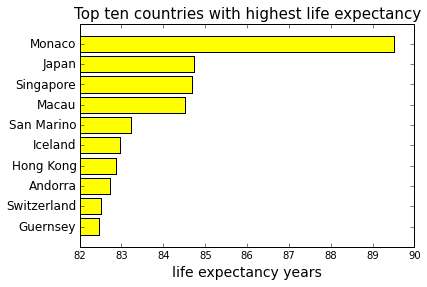

In [17]:
plt.barh(range(10),life.sort('(YEARS)', ascending=True)['(YEARS)'], color='yellow', align = 'center', linewidth = 1)
plt.title('Top ten countries with highest life expectancy', size=15)
plt.xlabel('life expectancy years', size=14)
# plt.ylabel('Countries')
plt.yticks(range(len(life))[::-1], life['Country'][::-1], size=12)
plt.xlim((82,90))
plt.ylim((-1,10))
plt.show()

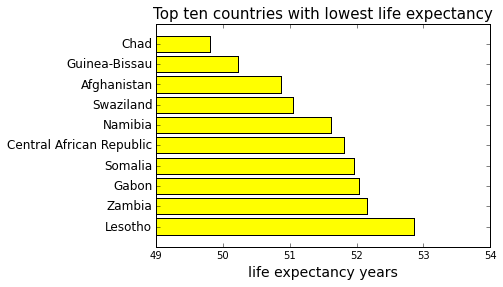

In [18]:
plt.barh(range(10),life_re.sort('(YEARS)', ascending=False)['(YEARS)'], color='yellow', align = 'center', linewidth = 1)
plt.title('Top ten countries with lowest life expectancy', size=15)
plt.xlabel('life expectancy years', size=14)
# plt.ylabel('Countries')
plt.yticks(range(len(life_re))[::-1], life_re['Country'][::-1], size=12)
plt.xlim((49,54))
plt.ylim((-1,10))
plt.show()

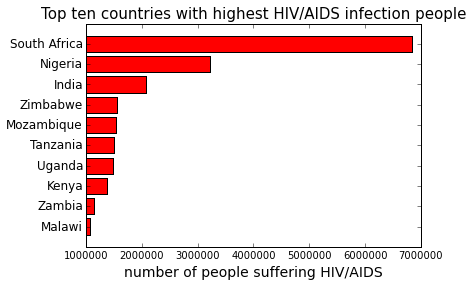

In [19]:
plt.barh(range(10),aids.sort('HIV', ascending=True)['HIV'], color='red', align = 'center', linewidth = 1)
plt.title('Top ten countries with highest HIV/AIDS infection people', size=15)
plt.xlabel('number of people suffering HIV/AIDS', size=14)
# plt.ylabel('Countries')
plt.yticks(range(len(aids))[::-1], aids['Country'][::-1], size=12)
plt.xlim((1000000,7000000))
plt.ylim((-1,10))
plt.show()

<h1>Further analysis</h1> 
To explore the correlation between three datasets

In [20]:
# Join life expectancy and expenditure tables
# on the basis of common country
df_1 = life_expectancy_df.join(expenditures_df, life_expectancy_df.Country == expenditures_df.Country,\
                               'inner').drop(expenditures_df.Country)
df_1.head()

Row(Rank=54, Country=u'Cyprus', (YEARS)=78.51, Date of Information=u'2015 est.', Rank=72, (% OF GDP)=7.3, Date of Information=2012)

In [21]:
# calculate the Pearson Correlation Coefficient 
# between life expectation and ratio of heath cost ratio
df_1.corr('(YEARS)', '(% OF GDP)')

0.1577899693655385

In [22]:
# calculate the sample covariance 
# between life expectation and ratio of heath cost ratio
df_1.cov('(YEARS)', '(% OF GDP)')

3.8624039424280405

In [23]:
df_1 = df_1.toPandas()

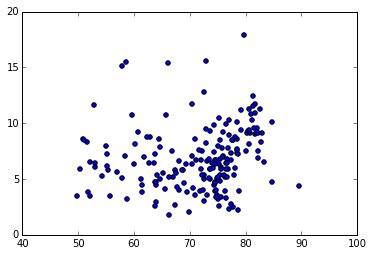

In [24]:
plt.scatter(df_1['(YEARS)'], df_1['(% OF GDP)'])
plt.show()

In [25]:
# Join life expectancy and HIV/AIDS suffering tables
# on the basis of common country
df_2 = life_expectancy_df.join(newhivaids_df, life_expectancy_df.Country == newhivaids_df.Country,\
                               'inner').drop(newhivaids_df.Country)
df_2.head()

Row(Rank=54, Country=u'Cyprus', (YEARS)=78.51, Date of Information=u'2015 est.', Rank=125, HIV=400, Date of Information=u'2013 est.')

In [26]:
# calculate the Pearson Correlation Coefficient 
# between life expectation and HIV/AIDS suffering
df_2.corr('(YEARS)', 'HIV')

-0.2660206161296163

In [27]:
# calculate the sample covariance 
# between life expectation and HIV/AIDS suffering
df_2.cov('(YEARS)', 'HIV')

-1776240.6170158724

In [28]:
df_2 = df_2.toPandas()

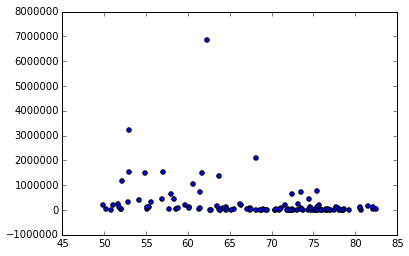

In [29]:
plt.scatter(df_2['(YEARS)'], df_2['HIV'])
plt.show()

In [30]:
# Join expenditure and HIV/AIDS suffering tables
# on the basis of common country
df_3 = expenditures_df.join(newhivaids_df, expenditures_df.Country == newhivaids_df.Country,\
                               'inner').drop(newhivaids_df.Country)
df_3.head()

Row(Rank=72, Country=u'Cyprus', (% OF GDP)=7.3, Date of Information=2012, Rank=125, HIV=400, Date of Information=u'2013 est.')

In [31]:
# calculate the Pearson Correlation Coefficient 
# between life expectation and HIV/AIDS suffering
df_3.corr('(% OF GDP)', 'HIV')

0.024248780176242424

In [32]:
# calculate the sample covariance 
# between life expectation and HIV/AIDS suffering
df_3.cov('(% OF GDP)', 'HIV')

44419.485161290424

In [33]:
df_3 = df_3.toPandas()

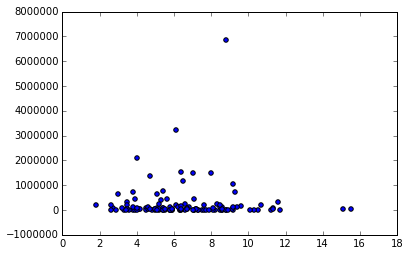

In [34]:
plt.scatter(df_3['(% OF GDP)'], df_3['HIV'])
plt.show()